# Importing Modules and initializing variables

Importing necessary modules that will be later required whilst training model


In [35]:
import numpy as np
import random
import heapq
import requests
import math
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Versions of the modules

In [36]:
print(np.__version__)
print(requests.__version__)

1.23.0
2.32.3


Global Variables

In [58]:
GRID_SIZE = 15
WEATHER_API_KEY = 'your_mom'

# Utilizing Open Weather services for wind and env

Extracting wind speed and wind degree

In [62]:
def get_owm_wind(lat, lon, api_key=WEATHER_API_KEY):
    url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()
    wind_data = data["wind"]
    #print(data)
    wind_speed = wind_data["speed"]  # m/s
    wind_deg   = wind_data.get("deg", 0)
    
    rain_1h = 0.0
    if "rain" in data and "1h" in data["rain"]:
       rain_1h = data["rain"]["1h"]
    snow_1h = 0.0
    if "snow" in data and "1h" in data["snow"]:
        snow_1h = data["snow"]["1h"]
    return wind_speed, wind_deg, rain_1h, snow_1h

Creating 2 by 2 dimension environment using winds

In [64]:
def generate_environment_with_owm(min_lat, max_lat, min_lon, max_lon,
                                   api_key=WEATHER_API_KEY, grid_size=10,
                                   wind_threshold=10.0,  # e.g. 10 m/s
                                   rain_threshold=2.0):  # e.g. 2 mm/h
    """
    Build a grid_size x grid_size environment with local weather data for each cell.
    - If wind_speed > wind_threshold or rain > rain_threshold => mark cell blocked (env[y,x]=1).
    - Otherwise, store wind[y,x]=(wy,wx) from local wind data.

    min_lat, max_lat, min_lon, max_lon define the bounding box.
    We'll do a simple per-cell call to the /weather endpoint for demonstration.
    """
    import time

    env = np.zeros((grid_size, grid_size), dtype=int)  # 0=free, 1=blocked
    wind = np.zeros((grid_size, grid_size, 2), dtype=float)

    lat_step = (max_lat - min_lat) / grid_size
    lon_step = (max_lon - min_lon) / grid_size

    for y in range(grid_size):
        for x in range(grid_size):
            # Center lat/lon of this cell
            cell_lat = min_lat + (y + 0.5)*lat_step
            cell_lon = min_lon + (x + 0.5)*lon_step

            wind_speed, wind_deg, rain_1h, snow_1h = get_owm_wind(cell_lat, cell_lon, api_key=WEATHER_API_KEY)
            
            radians = math.radians(wind_deg) # direction of wind
            
            wx = wind_speed * math.sin(radians)
            wy = -wind_speed * math.cos(radians)

            # 4) Decide if blocked
            # For example, if wind_speed > 10 m/s or rain + snow > 2 mm/h, block cell
            if (wind_speed > wind_threshold) or ((rain_1h + snow_1h) > rain_threshold):
                env[y, x] = 1  # blocked
            else:
                env[y, x] = 0

            # 5) Store wind vector
            wind[y, x] = (wy, wx)

            # (Optional) Avoid hammering the API too fast
            time.sleep(0.5)  # for demonstration, you might skip or reduce

    return env, wind

# A* Path Planner

Using A star algorithm for supervised imitation learning

In [65]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(node, grid_size):
    (y, x) = node
    for dy, dx in [(0,1),(0,-1),(1,0),(-1,0)]:
        ny, nx = y+dy, x+dx
        if 0 <= ny < grid_size and 0 <= nx < grid_size:
            yield (ny, nx)

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

def a_star(env, wind, start, goal):
    grid_size = env.shape[0]
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}

    g_score = {(y,x): float('inf') for y in range(grid_size) for x in range(grid_size)}
    f_score = {(y,x): float('inf') for y in range(grid_size) for x in range(grid_size)}

    g_score[start] = 0
    f_score[start] = heuristic(start, goal)

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)

        for nxt in get_neighbors(current, grid_size):
            cy, cx = current
            ny, nx = nxt
            if env[ny, nx] == 1:
                continue

            # Cost model
            step_cost = 1.0
            wy, wx = wind[ny, nx]
            step_cost += np.hypot(wy, wx)  # add wind magnitude
            tentative_g = g_score[current] + step_cost

            if tentative_g < g_score[nxt]:
                came_from[nxt] = current
                g_score[nxt] = tentative_g
                f_score[nxt] = tentative_g + heuristic(nxt, goal)
                heapq.heappush(open_set, (f_score[nxt], nxt))

    return None

Creating State Action pairs to follow policy

In [66]:
def path_to_state_action_pairs(path, wind, goal):
    pairs = []
    for i in range(len(path)-1):
        cy, cx = path[i]
        ny, nx = path[i+1]

        # define action
        if ny < cy:
            action = 0  # up
        elif ny > cy:
            action = 1  # down
        elif nx < cx:
            action = 2  # left
        else:
            action = 3  # right

        wy, wx = wind[cy, cx]
        gy, gx = goal
        state = (cy, cx, wy, wx, gy, gx)
        pairs.append((state, action))
    return pairs

# Training a supervised model

Creating a sample dataset to train the model on

In [67]:
def generate_dataset(num_scenarios=50, grid_size=GRID_SIZE):
    X, y = [], []
    for _ in range(num_scenarios):
        env, wind = generate_environment_with_owm(grid_size=grid_size, wind_scale=1.0)
        start = (0, 0)
        goal  = (grid_size-1, grid_size-1)
        if env[start] == 1 or env[goal] == 1:
            continue
        path = a_star(env, wind, start, goal)
        if path is None or len(path) < 2:
            continue
        pairs = path_to_state_action_pairs(path, wind, goal)
        for st, ac in pairs:
            X.append(st)
            y.append(ac)
    return X, y

Creating a function to convert the grid to latitude data

In [68]:
def define_bounding_box(lat_start, lon_start, lat_goal, lon_goal, extra_margin=0.5):
    """
    We define a bounding box that comfortably contains both start and goal,
    plus an extra margin (e.g. 20%) so there's room for alternative paths.

    Returns:
      (min_lat, max_lat, min_lon, max_lon)
    """
    min_lat = min(lat_start, lat_goal)
    max_lat = max(lat_start, lat_goal)
    min_lon = min(lon_start, lon_goal)
    max_lon = max(lon_start, lon_goal)

    lat_range = max_lat - min_lat
    lon_range = max_lon - min_lon

    # Expand by 'extra_margin' fraction
    min_lat -= lat_range * extra_margin
    max_lat += lat_range * extra_margin
    min_lon -= lon_range * extra_margin
    max_lon += lon_range * extra_margin

    return (min_lat, max_lat, min_lon, max_lon)

def latlon_to_grid(lat, lon, min_lat, max_lat, min_lon, max_lon, grid_size):
    """
    Convert real lat/lon to discrete grid coords:
      y in [0..grid_size-1]
      x in [0..grid_size-1]
    We'll do a simple linear mapping from [min_lat..max_lat] to [0..grid_size-1].
    """
    # clip to bounding box if out of range
    lat = max(min_lat, min(lat, max_lat))
    lon = max(min_lon, min(lon, max_lon))

    # fraction 0..1
    frac_y = (lat - min_lat) / (max_lat - min_lat) if (max_lat - min_lat)!=0 else 0
    frac_x = (lon - min_lon) / (max_lon - min_lon) if (max_lon - min_lon)!=0 else 0

    grid_y = int(frac_y * (grid_size - 1))
    grid_x = int(frac_x * (grid_size - 1))
    return (grid_y, grid_x)

def grid_to_latlon(grid_y, grid_x, min_lat, max_lat, min_lon, max_lon, grid_size):
    """
    Inverse of latlon_to_grid. 
    We map [0..grid_size-1] back to [min_lat..max_lat].
    """
    frac_y = grid_y / (grid_size - 1)
    frac_x = grid_x / (grid_size - 1)

    lat = min_lat + frac_y * (max_lat - min_lat)
    lon = min_lon + frac_x * (max_lon - min_lon)
    return (lat, lon)


Inferencing model

In [69]:
def model_based_route(model, env, wind, start, goal, max_steps=100):
    current = start
    path = []
    grid_size = env.shape[0]

    for _ in range(max_steps):
        path.append(current)
        if current == goal:
            return path

        cy, cx = current
        wy, wx = wind[cy, cx]
        gy, gx = goal
        state = np.array([cy,cx,wy,wx,gy,gx], dtype=float).reshape(1, -1)

        action = model.predict(state)[0]

        if action == 0:   # up
            ny, nx = cy-1, cx
        elif action == 1: # down
            ny, nx = cy+1, cx
        elif action == 2: # left
            ny, nx = cy, cx-1
        else:             # right
            ny, nx = cy, cx+1

        if not (0 <= ny < grid_size and 0 <= nx < grid_size):
            return None
        current = (ny, nx)

    return None

# Visualizing the model

Visualize the grid for ease in understanding the model.

In [70]:
def visualize(env, wind, path=None, start=None, goal=None, title=""):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(env, cmap='gray_r', origin='upper')
    skip = 1
    Y, X = np.mgrid[0:env.shape[0], 0:env.shape[1]]
    U = wind[...,1]
    V = wind[...,0]
    ax.quiver(X[::skip,::skip], Y[::skip,::skip], U[::skip,::skip], V[::skip,::skip],
              color='blue', scale=5, alpha=0.7)

    if path:
        py = [p[0] for p in path]
        px = [p[1] for p in path]
        ax.plot(px, py, 'ro-', label='Route')
    if start:
        ax.plot(start[1], start[0], 'gs', label='Start')
    if goal:
        ax.plot(goal[1], goal[0], 'rx', label='Goal')

    ax.legend()
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()


Grid start: (4, 14)
Grid goal: (14, 4)
A* path (grid coords): [(4, 14), (5, 14), (5, 13), (5, 12), (5, 11), (5, 10), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (10, 8), (11, 8), (11, 7), (12, 7), (12, 6), (13, 6), (13, 5), (14, 5), (14, 4)]
Model-based route (grid coords): [(4, 14), (5, 14), (5, 13), (5, 12), (5, 11), (5, 10), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (10, 8), (11, 8), (11, 7), (12, 7), (12, 6), (13, 6), (13, 5), (14, 5), (14, 4)]


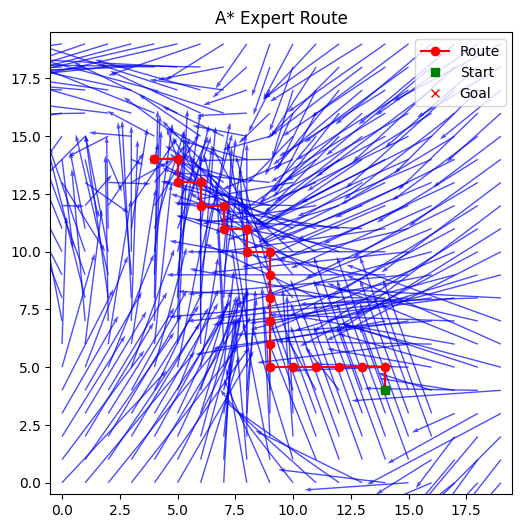

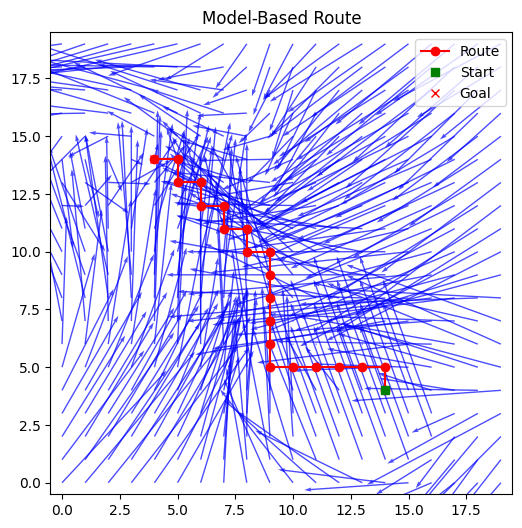

Model-based route in lat/lon:
(53.44262063157895, -113.53589878947369)
(53.54788378947369, -113.53589878947369)
(53.54788378947369, -113.64116194736843)
(53.54788378947369, -113.74642510526317)
(53.54788378947369, -113.8516882631579)
(53.54788378947369, -113.95695142105264)
(53.54788378947369, -114.06221457894738)
(53.65314694736842, -114.06221457894738)
(53.75841010526316, -114.06221457894738)
(53.8636732631579, -114.06221457894738)
(53.96893642105263, -114.06221457894738)
(54.07419957894737, -114.06221457894738)
(54.07419957894737, -114.16747773684212)
(54.179462736842105, -114.16747773684212)
(54.179462736842105, -114.27274089473684)
(54.284725894736845, -114.27274089473684)
(54.284725894736845, -114.37800405263158)
(54.389989052631584, -114.37800405263158)
(54.389989052631584, -114.48326721052632)
(54.49525221052632, -114.48326721052632)
(54.49525221052632, -114.58853036842106)
Model saved to route_model.pkl


In [74]:
if __name__ == "__main__":
    # Example: user gives real lat/lon for start & goal
    lat_start, lon_start = 53.521568, -113.509583
    lat_goal,  lon_goal  = 54.521568, -114.509583

    # 1) Define bounding box so we have a "radius" around them
    (min_lat, max_lat, min_lon, max_lon) = define_bounding_box(lat_start, lon_start, lat_goal, lon_goal, extra_margin=0.5)

    # 2) We take center for wind fetching
    lat_center = 0.5 * (min_lat + max_lat)
    lon_center = 0.5 * (min_lon + max_lon)

    # 3) Build environment from OWM
    env, wind_field = generate_environment_with_owm(
        min_lat, max_lat, min_lon, max_lon,
        api_key=WEATHER_API_KEY,
        grid_size=GRID_SIZE,
        wind_threshold=10.0,
        rain_threshold=2.0
    )

    # 4) Convert start/goal lat/lon => grid
    start_grid = latlon_to_grid(lat_start, lon_start, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    goal_grid  = latlon_to_grid(lat_goal,  lon_goal,  min_lat, max_lat, min_lon, max_lon, GRID_SIZE)

    print("Grid start:", start_grid)
    print("Grid goal:", goal_grid)

    # 5) A* route in grid coords
    astar_path = a_star(env, wind_field, start_grid, goal_grid)
    print("A* path (grid coords):", astar_path)

    if not astar_path or len(astar_path) < 2:
        print("No valid path found by A* => cannot train.")
        visualize(env, wind_field, path=None, start=start_grid, goal=goal_grid, title="No Route Found")
        exit()

    # 6) Convert path->(state->action), train model
    pairs = path_to_state_action_pairs(astar_path, wind_field, goal_grid)
    X_data = []
    y_data = []
    for (st, ac) in pairs:
        X_data.append(st)
        y_data.append(ac)

    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=10, random_state=42)
    X_np = np.array(X_data, dtype=float)
    y_np = np.array(y_data, dtype=int)
    model.fit(X_np, y_np)

    # 7) Model-based route
    model_path = model_based_route(model, env, wind_field, start_grid, goal_grid, max_steps=100)
    print("Model-based route (grid coords):", model_path)

    # 8) Visualization in grid coords
    visualize(env, wind_field, path=astar_path, start=start_grid, goal=goal_grid, title="A* Expert Route")
    visualize(env, wind_field, path=model_path, start=start_grid, goal=goal_grid, title="Model-Based Route")

    # 9) Convert final route to lat/lon
    if model_path:
        latlon_route = []
        for (gy, gx) in model_path:
            lat_c, lon_c = grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
            latlon_route.append((lat_c, lon_c))

        print("Model-based route in lat/lon:")
        for coords in latlon_route:
            print(coords)

    # 10) (Optional) Save the model
    with open("route_model.pkl","wb") as f:
        pickle.dump(model, f)
    print("Model saved to route_model.pkl")